In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('data/shepard_energy_consumption.xlsx')
data.rename(columns={'CUNY City College of New York - 2018-09-01 -> 2023-08-31': 'Timestamp'}, inplace=True)
data.drop(data.index[0], inplace=True)
data.rename(columns={'12785711': 'Meter1'}, inplace=True)
data.rename(columns={'12785712': 'Meter2'}, inplace=True)



In [3]:
data.head()

,Timestamp,Meter1,Meter2
1,2018-09-01 01:00:00,124,217.5
2,2018-09-01 02:00:00,124,218
3,2018-09-01 03:00:00,126,216.5
4,2018-09-01 04:00:00,124,216
5,2018-09-01 05:00:00,122.5,219


In [4]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data.set_index('Timestamp', inplace=True)



In [5]:
data.head()

,Meter1,Meter2
Timestamp,,
2018-09-01 01:00:00,124,217.5
2018-09-01 02:00:00,124,218
2018-09-01 03:00:00,126,216.5
2018-09-01 04:00:00,124,216
2018-09-01 05:00:00,122.5,219


In [6]:
# Nomalize data for meter1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Meter1'].values.reshape(-1, 1))

In [7]:
print(scaled_data[0:25])
scaled_data[24]

[[0.55555556]
 [0.55555556]
 [0.56790123]
 [0.55555556]
 [0.5462963 ]
 [0.54938272]
 [0.53395062]
 [0.54012346]
 [0.5462963 ]
 [0.55246914]
 [0.54320988]
 [0.54012346]
 [0.54012346]
 [0.54012346]
 [0.54320988]
 [0.54012346]
 [0.54938272]
 [0.58333333]
 [0.57407407]
 [0.57098765]
 [0.57407407]
 [0.57716049]
 [0.56790123]
 [0.5617284 ]
 [0.55864198]]


array([0.55864198])

In [8]:
# Function to create dataset for LSTM
# stores values in array X that will be used to predict value in correspending index in Y
# first iteration
# 0-23 values stored in X, 24th value stored in Y(target value)
# second iteration 
# 1-24 stored in X, 25th value stored in Y
def create_dataset(dataset, look_back=24):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1): #ensures that loop stops at a point where there is enough datapoints for a last X, and Y set
        a = dataset[i:(i + look_back), 0]  #slices values in dataset from i to i+24
        X.append(a)
        Y.append(dataset[i + look_back, 0]) # stores the value right after a into Y
    return np.array(X), np.array(Y)

In [9]:
# Creating the dataset suitable for LSTM
X, Y = create_dataset(scaled_data)

In [10]:
print(X[0])
print(Y[0])

[0.55555556 0.55555556 0.56790123 0.55555556 0.5462963  0.54938272
 0.53395062 0.54012346 0.5462963  0.55246914 0.54320988 0.54012346
 0.54012346 0.54012346 0.54320988 0.54012346 0.54938272 0.58333333
 0.57407407 0.57098765 0.57407407 0.57716049 0.56790123 0.5617284 ]
0.558641975308642


In [11]:
print(X.shape[1])


24


In [30]:


# Reshaping input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Splitting the dataset into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [31]:
X.shape

(43799, 24, 1)

In [14]:

# Building the LSTM network
## sequential model means layers are a linear stack where layers can be added one after another 
model = Sequential()
## first layer has 50 neurons, inpputshape(time steps, features) return_sequences because there is another layer
model.add(LSTM(50, input_shape=(X_train.shape[1], 1), return_sequences=True))
# second and last layer 
model.add(LSTM(50))
# output for final predictin Dense means the neuron is fully connected with previous neurons
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Training the model
model.fit(X_train, Y_train, epochs=5, batch_size=32, verbose=1)
#model starts processing data in X_train and amkes predictions for y_train adjusts every epoch based on MSE thus training it 

Epoch 1/5
1095/1095 [==============================] - 44s 32ms/step - loss: 0.0025
Epoch 2/5
1095/1095 [==============================] - 36s 33ms/step - loss: 5.6584e-04
Epoch 3/5
1095/1095 [==============================] - 35s 32ms/step - loss: 4.6106e-04
Epoch 4/5
1095/1095 [==============================] - 35s 32ms/step - loss: 4.3968e-04
Epoch 5/5
1095/1095 [==============================] - 35s 32ms/step - loss: 4.4247e-04


In [17]:
train_predict = model.predict(X_train)
# model makes prediction for energy output based on previously seen data
#train_predict should predict the valyes in Y_train
test_predict = model.predict(X_test)
# model makes predictions based of new data
# test_predict should predict the valyes in Y_test

274/274 [==============================] - 4s 14ms/step


In [18]:

# Inverting predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train_inv = scaler.inverse_transform([Y_train])
Y_test_inv = scaler.inverse_transform([Y_test])

In [19]:
Y_train_inv.shape
print(Y_train_inv[0])


[124.5 124.5 123.5 ... 115.  109.5 109.5]


In [20]:
# Calculating RMSE
train_rmse = np.sqrt(mean_squared_error(Y_train_inv[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv[0], test_predict[:,0]))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 3.281759837958102
Test RMSE: 4.134070019180842


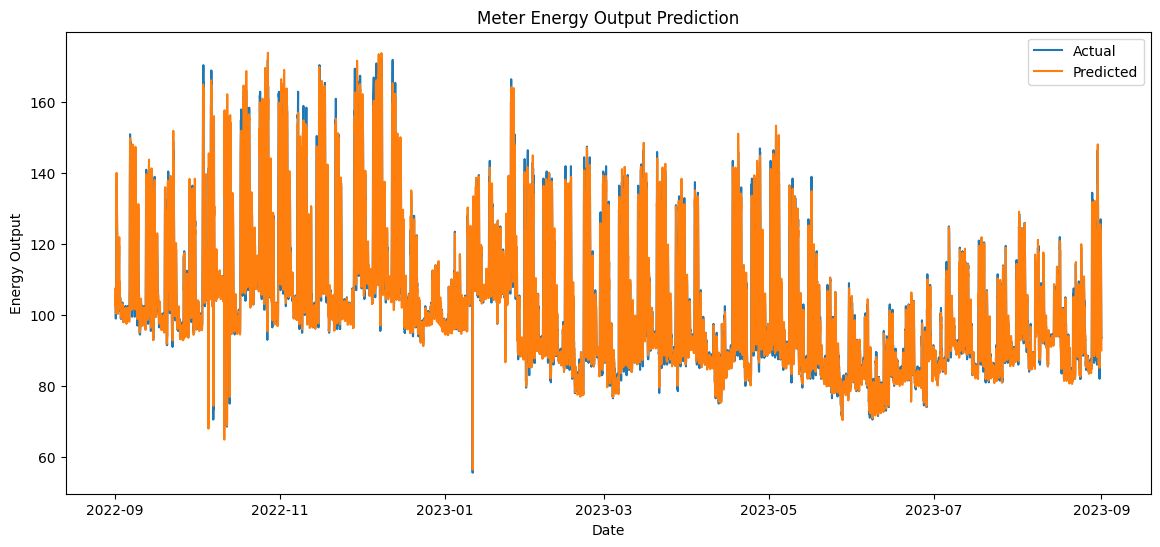

In [21]:
# Plotting the results
plt.figure(figsize=(14, 6))
plt.plot(data['Meter1'][-len(Y_test):].index, Y_test_inv[0], label='Actual')
plt.plot(data['Meter1'][-len(Y_test):].index, test_predict[:, 0], label='Predicted')
plt.title('Meter Energy Output Prediction')
plt.xlabel('Date')
plt.ylabel('Energy Output')
plt.legend()
plt.show()

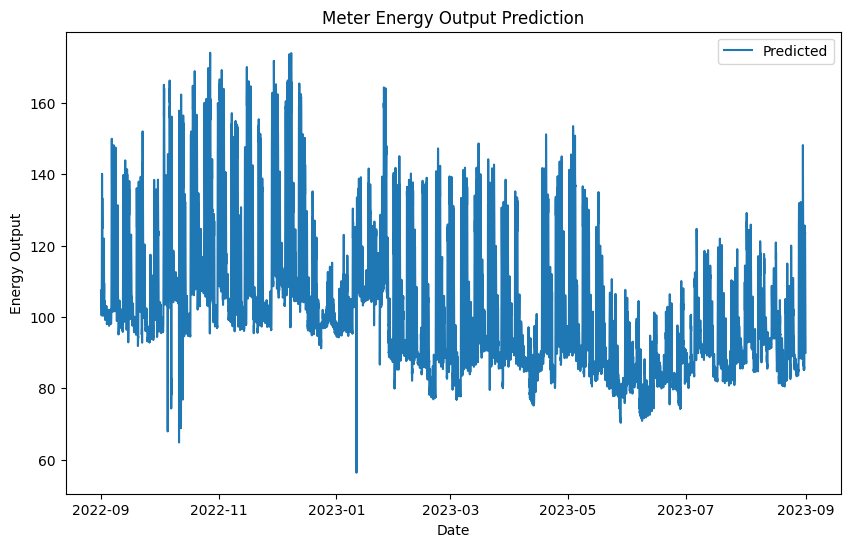

In [22]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(data['Meter1'][-len(Y_test):].index, test_predict[:, 0], label='Predicted')
plt.title('Meter Energy Output Prediction')
plt.xlabel('Date')
plt.ylabel('Energy Output')
plt.legend()
plt.show()

In [23]:
recent_data_week = data['Meter1'][-24:]
scaled_recent_data_week = scaler.transform(recent_data_week.values.reshape(-1,1))
print(scaled_recent_data_week)

[[0.32098765]
 [0.31790123]
 [0.3117284 ]
 [0.30864198]
 [0.29938272]
 [0.2962963 ]
 [0.30246914]
 [0.32716049]
 [0.36111111]
 [0.4845679 ]
 [0.53395062]
 [0.54938272]
 [0.5308642 ]
 [0.55555556]
 [0.5617284 ]
 [0.57407407]
 [0.54938272]
 [0.53703704]
 [0.5       ]
 [0.44135802]
 [0.40123457]
 [0.36728395]
 [0.36728395]
 [0.36419753]]


In [24]:
sequence_week = np.reshape(scaled_recent_data_week, (1, 24, 1))
predictions_week = []

In [25]:
for i in range(7*24):  # Loop for 7 days 24 hours a day 
    daily_prediction_scaled = model.predict(sequence_week)
    daily_prediction = scaler.inverse_transform(daily_prediction_scaled)
    predictions_week.append(daily_prediction[0, 0])
    
    # Update the sequence: roll and append the new prediction
    sequence_week = np.roll(sequence_week, -1)
    sequence_week[0, -1, 0] = daily_prediction_scaled[0, 0]

1/1 [==============================] - 0s 48ms/step


In [26]:
print(len(predictions_week))
print(predictions_week)


168
[91.30379, 90.07464, 89.514725, 89.74781, 90.78986, 92.58949, 95.0284, 97.92514, 101.038956, 104.09189, 106.757774, 108.79614, 110.05873, 110.496666, 110.12, 109.02046, 107.33864, 105.257324, 102.95384, 100.59998, 98.34824, 96.31295, 94.57927, 93.19654, 92.19877, 91.60733, 91.425705, 91.637314, 92.20389, 93.065125, 94.14037, 95.33284, 96.53634, 97.644196, 98.55952, 99.20496, 99.5301, 99.51504, 99.16991, 98.530785, 97.653046, 96.60365, 95.45392, 94.2733, 93.12496, 92.06285, 91.13006, 90.35802, 89.76628, 89.3626, 89.14327, 89.09361, 89.18911, 89.39686, 89.67769, 89.98897, 90.287605, 90.5334, 90.69205, 90.73781, 90.65498, 90.43865, 90.0941, 89.63549, 89.08384, 88.46459, 87.805244, 87.13322, 86.47393, 85.84938, 85.27716, 84.7698, 84.33454, 83.97325, 83.68286, 83.45574, 83.28061, 83.14335, 83.02818, 82.91884, 82.79963, 82.65666, 82.47865, 82.25756, 81.989, 81.67221, 81.30983, 80.90737, 80.472565, 80.01452, 79.54299, 79.06767, 78.59741, 78.13987, 77.700966, 77.28477, 76.893364, 76.52692,

In [27]:
# Start and end dates
start_date = pd.to_datetime('2023-09-01 01:00')
end_date = pd.to_datetime('2023-09-08 00:00')  

# Generate a list of hourly timestamps
timestamps = pd.date_range(start=start_date, end=end_date, freq='H')

In [28]:
print(len(timestamps))
print(len(predictions_week))


168
168


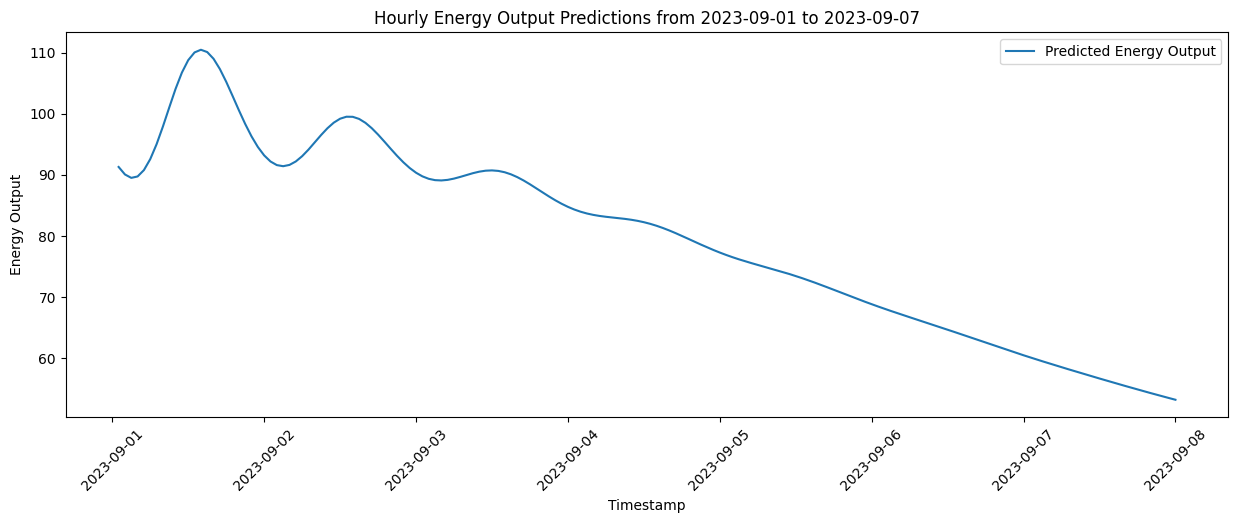

In [29]:
plt.figure(figsize=(15, 5))  # Adjust the size as needed
plt.plot(timestamps, predictions_week, label='Predicted Energy Output')
plt.xlabel('Timestamp')
plt.ylabel('Energy Output')
plt.title('Hourly Energy Output Predictions from 2023-09-01 to 2023-09-07')
plt.xticks(rotation=45)  # Rotates the X-axis labels for readability
plt.legend()
plt.show()

In [ ]:
recent_data_month = data['Meter1'][-24:]
scaled_recent_data_month = scaler.transform(recent_data_month.values.reshape(-1,1))
sequence_month = np.reshape(scaled_recent_data_month, (1,24,1))
print(scaled_recent_data_month)

In [ ]:
predictions_month = []
for i in range(30 * 24):  # 30 days * 24 hours
    hourly_prediction_scaled = model.predict(sequence_month)
    hourly_prediction = scaler.inverse_transform(hourly_prediction_scaled)
    predictions_month.append(hourly_prediction[0, 0])

    sequence_month = np.roll(sequence_month, -1)
    sequence_month[0, -1, 0] = hourly_prediction_scaled[0, 0]


In [ ]:
start_date_month = pd.to_datetime('2023-09-01 00:00')
end_date_month = pd.to_datetime('2023-09-30 23:00')
timestamps_month = pd.date_range(start=start_date_month, end=end_date_month, freq='H')


In [ ]:
print(len(timestamps_month))
print(len(predictions_month))


In [ ]:
print(predictions_month)

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(timestamps_month, predictions_month, label='Predicted Energy Output')
plt.xlabel('Timestamp')
plt.ylabel('Energy Output')
plt.title('Hourly Energy Output Predictions for September 2023')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [ ]:
import csv

In [ ]:
with open('week_predictions.csv', 'w', newline='')as file:
    writer = csv.writer(file)
    for prediction in predictions_week:
        writer.writerow([prediction])